# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.23KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

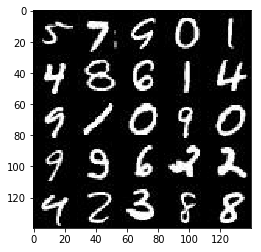

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

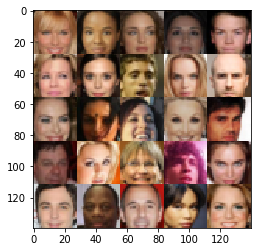

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [88]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2 # As shown in the 'DCGAN' IPython notebook

        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits

# n_units = 128 # As shown in the 'Intro-to-GANs' IPython notebook
#         # Add hidden layer
#         h1 = tf.layers.dense(images, n_units, activation=None)
#         # Add leaky ReLu
#         h1 = tf.maximum(alpha * h1, h1)
        
#         logits = tf.layers.dense(h1, 1, activation=None)
#         out = tf.sigmoid(logits)
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [89]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    if is_train == True:
        reuse = False
    else:
        reuse = True
    
    with tf.variable_scope('generator', reuse=reuse):
        alpha = 0.2
        # First FC layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape to start CNN stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [90]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                               labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                               labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                               labels=tf.ones_like(d_model_fake)))
    
    # NB: g_loss is driven entirely by how well the discriminator's logits
    # from fake data aligns to all label 1s. Antagonistically, the d_loss is driven
    # by the ability of the discriminator to maximize alignment of real data
    # to label 1s and fake data to label 0s. The end of the 2-player game is
    # reached as they approach Nash equilibrium, which is when the discriminator
    # simply outputs ~1/2 for both real and fake data.
    
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [91]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    training_variables = tf.trainable_variables()
    d_vars = [var for var in training_variables if var.name.startswith('discriminator')]
    g_vars = [var for var in training_variables if var.name.startswith('generator')]
    
    # Begin optimization
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [92]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [93]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     tf.reset_default_graph()
    
    # Define data parameters
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    out_channel_dim = image_channels
    
    # Collect tf input placeholders
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Calculate losses
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    # Setup optimization schema
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Prepare for training
    saver = tf.train.Saver()
    
    losses = []
    steps = 0
    print_every = 25
    show_every = 100
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2.0 # Transform range to [-1, 1]; this one line was added with outside help
                
                # Sample noise for generator
                batch_z = np.random.uniform(-1,1, size = (batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict = {input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    
                    show_generator_output(sess, 
                                          n_images, 
                                          input_z,
                                          out_channel_dim, 
                                          data_image_mode)

#         saver.save(sess, './checkpoints/generator.ckpt')
        
#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
        
    return losses      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2967 Generator Loss: 6.0932
Epoch 1/2... Discriminator Loss: 1.5865 Generator Loss: 1.9738
Epoch 1/2... Discriminator Loss: 1.7368 Generator Loss: 0.6558
Epoch 1/2... Discriminator Loss: 1.9670 Generator Loss: 0.2394


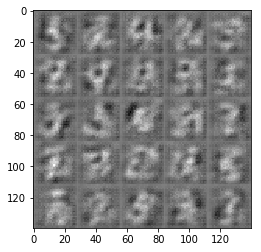

Epoch 1/2... Discriminator Loss: 1.1519 Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 1.3368 Generator Loss: 0.4703
Epoch 1/2... Discriminator Loss: 1.1290 Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.2056 Generator Loss: 1.7489


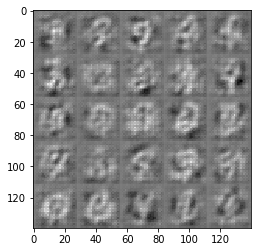

Epoch 1/2... Discriminator Loss: 0.9991 Generator Loss: 0.6166
Epoch 1/2... Discriminator Loss: 0.4723 Generator Loss: 1.6118
Epoch 1/2... Discriminator Loss: 0.8380 Generator Loss: 2.2704
Epoch 1/2... Discriminator Loss: 0.9958 Generator Loss: 0.6989


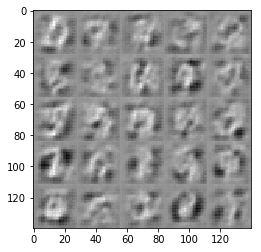

Epoch 1/2... Discriminator Loss: 0.4007 Generator Loss: 1.6729
Epoch 1/2... Discriminator Loss: 0.7932 Generator Loss: 2.7974
Epoch 1/2... Discriminator Loss: 1.1262 Generator Loss: 0.4902
Epoch 1/2... Discriminator Loss: 0.2851 Generator Loss: 2.6933


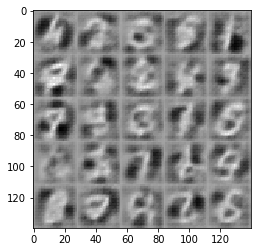

Epoch 1/2... Discriminator Loss: 0.7940 Generator Loss: 2.1354
Epoch 1/2... Discriminator Loss: 1.4225 Generator Loss: 3.5971
Epoch 1/2... Discriminator Loss: 1.1531 Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 1.1395 Generator Loss: 0.7373


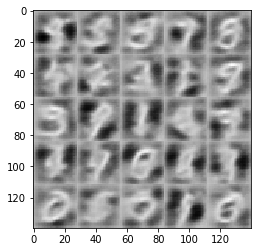

Epoch 1/2... Discriminator Loss: 1.3065 Generator Loss: 0.4636
Epoch 1/2... Discriminator Loss: 1.2158 Generator Loss: 0.5609
Epoch 1/2... Discriminator Loss: 1.1211 Generator Loss: 0.7816
Epoch 1/2... Discriminator Loss: 1.4201 Generator Loss: 0.4062


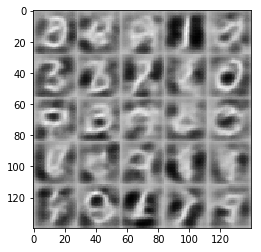

Epoch 1/2... Discriminator Loss: 1.1198 Generator Loss: 0.6320
Epoch 1/2... Discriminator Loss: 1.1704 Generator Loss: 1.3196
Epoch 1/2... Discriminator Loss: 1.2016 Generator Loss: 0.5743
Epoch 1/2... Discriminator Loss: 1.2931 Generator Loss: 0.4139


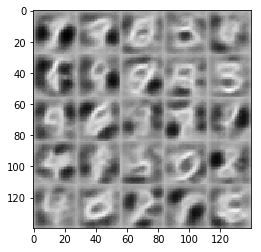

Epoch 1/2... Discriminator Loss: 0.8821 Generator Loss: 1.3082
Epoch 1/2... Discriminator Loss: 1.6056 Generator Loss: 0.2824
Epoch 1/2... Discriminator Loss: 1.1580 Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 1.4726 Generator Loss: 0.3426


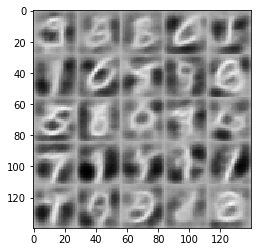

Epoch 1/2... Discriminator Loss: 1.1997 Generator Loss: 0.8826
Epoch 1/2... Discriminator Loss: 1.5684 Generator Loss: 0.3221
Epoch 1/2... Discriminator Loss: 1.1016 Generator Loss: 0.6695
Epoch 1/2... Discriminator Loss: 1.3113 Generator Loss: 0.4404


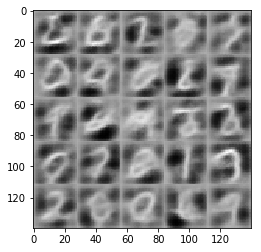

Epoch 1/2... Discriminator Loss: 1.1262 Generator Loss: 1.1580
Epoch 1/2... Discriminator Loss: 1.7733 Generator Loss: 0.2433
Epoch 1/2... Discriminator Loss: 1.6188 Generator Loss: 0.3139
Epoch 1/2... Discriminator Loss: 1.1277 Generator Loss: 0.9348


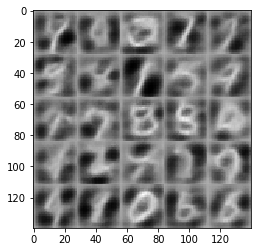

Epoch 1/2... Discriminator Loss: 1.0617 Generator Loss: 0.6575
Epoch 1/2... Discriminator Loss: 1.5320 Generator Loss: 0.3000
Epoch 1/2... Discriminator Loss: 1.8291 Generator Loss: 0.2272
Epoch 1/2... Discriminator Loss: 1.0567 Generator Loss: 1.0464


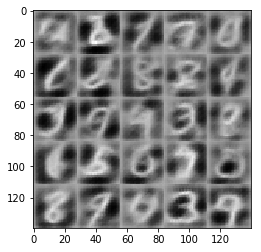

Epoch 1/2... Discriminator Loss: 1.8746 Generator Loss: 0.2177
Epoch 1/2... Discriminator Loss: 0.8457 Generator Loss: 0.9355
Epoch 1/2... Discriminator Loss: 1.0864 Generator Loss: 1.5503
Epoch 1/2... Discriminator Loss: 1.3548 Generator Loss: 0.4292


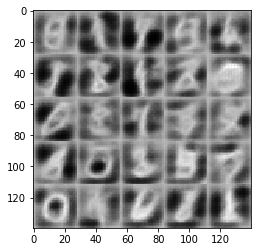

Epoch 1/2... Discriminator Loss: 1.0992 Generator Loss: 0.7553
Epoch 1/2... Discriminator Loss: 1.3797 Generator Loss: 2.3034
Epoch 1/2... Discriminator Loss: 1.0282 Generator Loss: 0.7829
Epoch 1/2... Discriminator Loss: 0.8777 Generator Loss: 0.6847


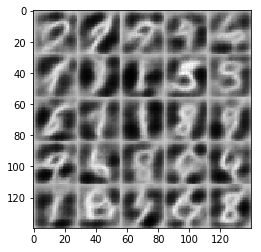

Epoch 1/2... Discriminator Loss: 0.9118 Generator Loss: 0.8784
Epoch 1/2... Discriminator Loss: 1.2395 Generator Loss: 0.4896
Epoch 1/2... Discriminator Loss: 0.8796 Generator Loss: 1.1750
Epoch 1/2... Discriminator Loss: 1.3219 Generator Loss: 0.4433


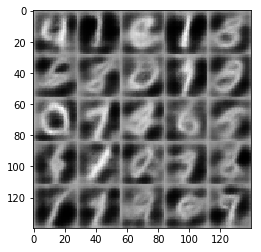

Epoch 1/2... Discriminator Loss: 1.0265 Generator Loss: 0.6033
Epoch 1/2... Discriminator Loss: 1.2586 Generator Loss: 2.0552
Epoch 1/2... Discriminator Loss: 1.3390 Generator Loss: 0.4042
Epoch 1/2... Discriminator Loss: 0.8784 Generator Loss: 0.8718


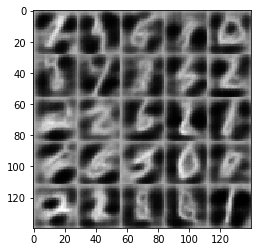

Epoch 1/2... Discriminator Loss: 1.2408 Generator Loss: 2.4703
Epoch 1/2... Discriminator Loss: 1.0358 Generator Loss: 0.6145
Epoch 1/2... Discriminator Loss: 0.7794 Generator Loss: 1.3873
Epoch 1/2... Discriminator Loss: 0.7895 Generator Loss: 1.1410


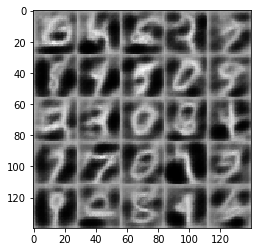

Epoch 1/2... Discriminator Loss: 2.0152 Generator Loss: 0.2097
Epoch 1/2... Discriminator Loss: 0.9286 Generator Loss: 0.8934
Epoch 1/2... Discriminator Loss: 1.0037 Generator Loss: 0.6624
Epoch 1/2... Discriminator Loss: 0.8976 Generator Loss: 0.9870


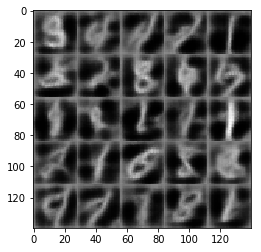

Epoch 1/2... Discriminator Loss: 0.8694 Generator Loss: 0.8412
Epoch 1/2... Discriminator Loss: 0.6020 Generator Loss: 1.0862
Epoch 1/2... Discriminator Loss: 1.2186 Generator Loss: 0.4634
Epoch 1/2... Discriminator Loss: 0.6208 Generator Loss: 0.9858


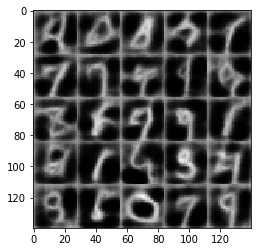

Epoch 1/2... Discriminator Loss: 1.2844 Generator Loss: 1.8136
Epoch 1/2... Discriminator Loss: 0.7015 Generator Loss: 1.1016
Epoch 1/2... Discriminator Loss: 0.6974 Generator Loss: 0.9716
Epoch 2/2... Discriminator Loss: 1.1957 Generator Loss: 0.4971


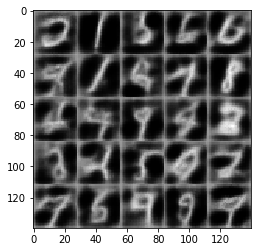

Epoch 2/2... Discriminator Loss: 0.9089 Generator Loss: 0.6809
Epoch 2/2... Discriminator Loss: 2.0421 Generator Loss: 0.2401
Epoch 2/2... Discriminator Loss: 0.5951 Generator Loss: 1.0074
Epoch 2/2... Discriminator Loss: 0.6810 Generator Loss: 1.0472


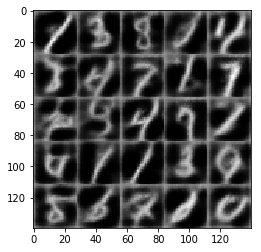

Epoch 2/2... Discriminator Loss: 0.6578 Generator Loss: 1.1947
Epoch 2/2... Discriminator Loss: 0.7910 Generator Loss: 0.8732
Epoch 2/2... Discriminator Loss: 1.0226 Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 1.0439 Generator Loss: 0.5658


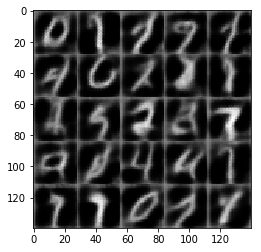

Epoch 2/2... Discriminator Loss: 0.3282 Generator Loss: 1.9652
Epoch 2/2... Discriminator Loss: 0.7980 Generator Loss: 1.0468
Epoch 2/2... Discriminator Loss: 0.5624 Generator Loss: 2.3120
Epoch 2/2... Discriminator Loss: 0.9774 Generator Loss: 0.6368


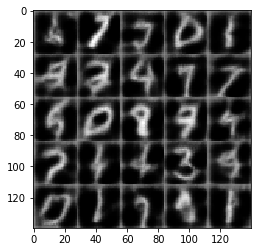

Epoch 2/2... Discriminator Loss: 0.6533 Generator Loss: 1.2314
Epoch 2/2... Discriminator Loss: 0.6999 Generator Loss: 1.2615
Epoch 2/2... Discriminator Loss: 0.7905 Generator Loss: 1.3592
Epoch 2/2... Discriminator Loss: 0.9110 Generator Loss: 1.3445


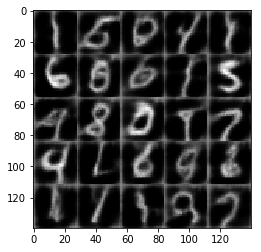

Epoch 2/2... Discriminator Loss: 0.8807 Generator Loss: 0.7730
Epoch 2/2... Discriminator Loss: 0.4755 Generator Loss: 1.5636
Epoch 2/2... Discriminator Loss: 1.2165 Generator Loss: 0.4794
Epoch 2/2... Discriminator Loss: 0.6771 Generator Loss: 0.8760


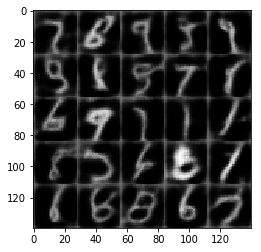

Epoch 2/2... Discriminator Loss: 1.2502 Generator Loss: 0.5503
Epoch 2/2... Discriminator Loss: 0.4892 Generator Loss: 1.6510
Epoch 2/2... Discriminator Loss: 0.5636 Generator Loss: 1.1381
Epoch 2/2... Discriminator Loss: 0.6821 Generator Loss: 1.3780


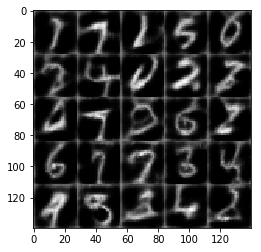

Epoch 2/2... Discriminator Loss: 1.1022 Generator Loss: 0.5379
Epoch 2/2... Discriminator Loss: 0.9172 Generator Loss: 0.7249
Epoch 2/2... Discriminator Loss: 0.3932 Generator Loss: 1.4872
Epoch 2/2... Discriminator Loss: 0.4922 Generator Loss: 1.7388


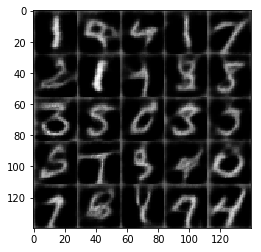

Epoch 2/2... Discriminator Loss: 0.5913 Generator Loss: 1.3329
Epoch 2/2... Discriminator Loss: 0.6452 Generator Loss: 1.0071
Epoch 2/2... Discriminator Loss: 1.1635 Generator Loss: 0.5009
Epoch 2/2... Discriminator Loss: 0.7344 Generator Loss: 1.0616


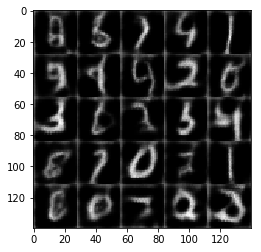

Epoch 2/2... Discriminator Loss: 1.2148 Generator Loss: 0.4833
Epoch 2/2... Discriminator Loss: 0.4015 Generator Loss: 2.1526
Epoch 2/2... Discriminator Loss: 0.9010 Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 0.5471 Generator Loss: 1.2213


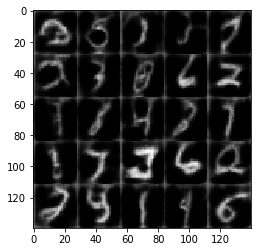

Epoch 2/2... Discriminator Loss: 0.9636 Generator Loss: 0.7201
Epoch 2/2... Discriminator Loss: 0.4899 Generator Loss: 1.3237
Epoch 2/2... Discriminator Loss: 0.3247 Generator Loss: 1.7064
Epoch 2/2... Discriminator Loss: 0.8394 Generator Loss: 0.8880


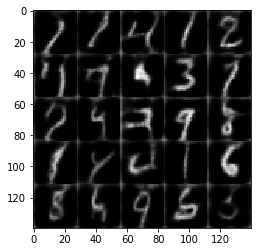

Epoch 2/2... Discriminator Loss: 0.6236 Generator Loss: 1.5446
Epoch 2/2... Discriminator Loss: 0.4813 Generator Loss: 2.6048
Epoch 2/2... Discriminator Loss: 1.0669 Generator Loss: 0.5357
Epoch 2/2... Discriminator Loss: 0.5448 Generator Loss: 1.0563


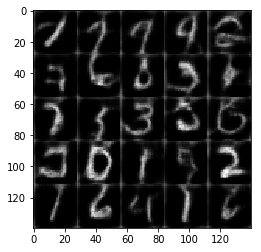

Epoch 2/2... Discriminator Loss: 0.7291 Generator Loss: 0.8895
Epoch 2/2... Discriminator Loss: 0.8562 Generator Loss: 1.6862
Epoch 2/2... Discriminator Loss: 0.7745 Generator Loss: 0.8115
Epoch 2/2... Discriminator Loss: 0.7353 Generator Loss: 1.0728


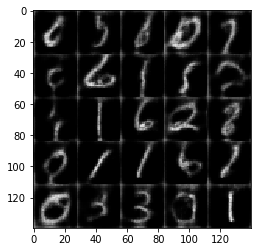

Epoch 2/2... Discriminator Loss: 0.6695 Generator Loss: 1.9202
Epoch 2/2... Discriminator Loss: 0.7526 Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 1.8220 Generator Loss: 0.3162
Epoch 2/2... Discriminator Loss: 0.6484 Generator Loss: 1.0429


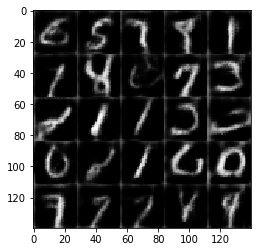

Epoch 2/2... Discriminator Loss: 0.7230 Generator Loss: 1.0320
Epoch 2/2... Discriminator Loss: 0.4578 Generator Loss: 1.5695
Epoch 2/2... Discriminator Loss: 0.5098 Generator Loss: 1.3078
Epoch 2/2... Discriminator Loss: 2.3257 Generator Loss: 0.2096


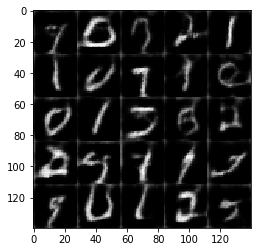

Epoch 2/2... Discriminator Loss: 0.8549 Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 0.9915 Generator Loss: 0.6537
Epoch 2/2... Discriminator Loss: 1.0372 Generator Loss: 0.5976
Epoch 2/2... Discriminator Loss: 0.4359 Generator Loss: 1.3709


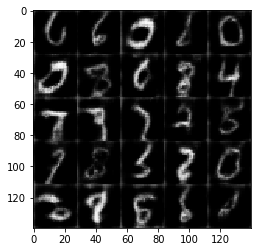

Epoch 2/2... Discriminator Loss: 2.4380 Generator Loss: 5.3637
Epoch 2/2... Discriminator Loss: 0.4468 Generator Loss: 2.4992
Epoch 2/2... Discriminator Loss: 0.4820 Generator Loss: 1.2246
Epoch 2/2... Discriminator Loss: 0.3199 Generator Loss: 1.6016


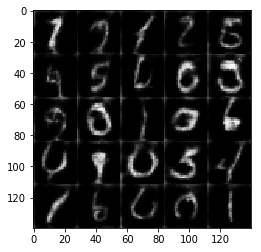

Epoch 2/2... Discriminator Loss: 0.6823 Generator Loss: 0.9695
Epoch 2/2... Discriminator Loss: 1.3264 Generator Loss: 0.4576
Epoch 2/2... Discriminator Loss: 1.1635 Generator Loss: 2.3306
Epoch 2/2... Discriminator Loss: 0.3004 Generator Loss: 2.2639


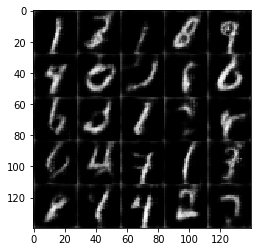

Epoch 2/2... Discriminator Loss: 0.7379 Generator Loss: 0.8639
Epoch 2/2... Discriminator Loss: 1.3869 Generator Loss: 0.4454
Epoch 2/2... Discriminator Loss: 2.1618 Generator Loss: 0.1838
Epoch 2/2... Discriminator Loss: 0.6078 Generator Loss: 0.9235


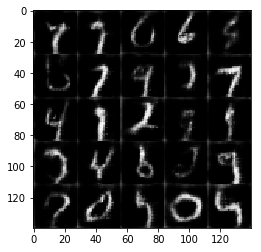

Epoch 2/2... Discriminator Loss: 0.8596 Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 0.7219 Generator Loss: 0.8810


In [94]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3685 Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 0.6687 Generator Loss: 1.4939
Epoch 1/1... Discriminator Loss: 1.6189 Generator Loss: 0.3313
Epoch 1/1... Discriminator Loss: 1.3668 Generator Loss: 1.6541


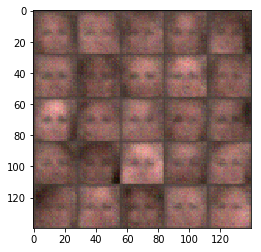

Epoch 1/1... Discriminator Loss: 1.5048 Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 1.3782 Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.5819 Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 2.1796 Generator Loss: 0.1499


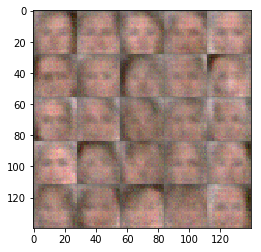

Epoch 1/1... Discriminator Loss: 0.9797 Generator Loss: 2.2329
Epoch 1/1... Discriminator Loss: 1.4444 Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 0.7033 Generator Loss: 2.1000
Epoch 1/1... Discriminator Loss: 0.7429 Generator Loss: 1.6780


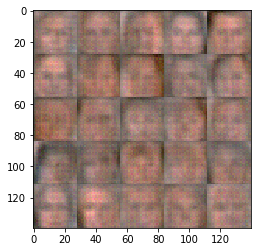

Epoch 1/1... Discriminator Loss: 1.2157 Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 0.9779 Generator Loss: 1.8069
Epoch 1/1... Discriminator Loss: 0.8396 Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.3484 Generator Loss: 1.5978


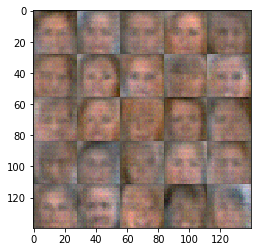

Epoch 1/1... Discriminator Loss: 1.0025 Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 0.9041 Generator Loss: 2.5193
Epoch 1/1... Discriminator Loss: 1.4276 Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 1.2957 Generator Loss: 1.5596


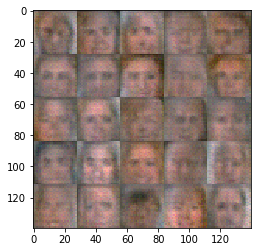

Epoch 1/1... Discriminator Loss: 1.1789 Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 0.9587 Generator Loss: 1.6012
Epoch 1/1... Discriminator Loss: 1.5223 Generator Loss: 2.4601
Epoch 1/1... Discriminator Loss: 1.9219 Generator Loss: 0.1954


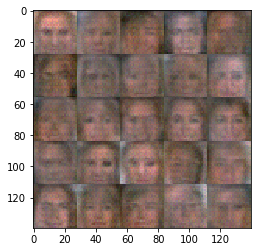

Epoch 1/1... Discriminator Loss: 1.3010 Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.4530 Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 1.6451 Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.5850 Generator Loss: 1.3792


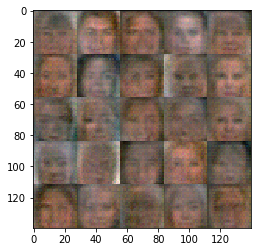

Epoch 1/1... Discriminator Loss: 1.5823 Generator Loss: 0.3385
Epoch 1/1... Discriminator Loss: 0.8195 Generator Loss: 1.6500
Epoch 1/1... Discriminator Loss: 1.3192 Generator Loss: 0.4467
Epoch 1/1... Discriminator Loss: 1.4804 Generator Loss: 0.6863


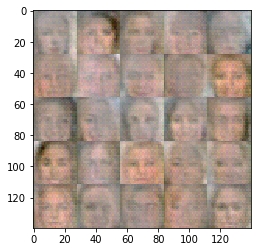

Epoch 1/1... Discriminator Loss: 1.0602 Generator Loss: 2.2723
Epoch 1/1... Discriminator Loss: 0.7945 Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 0.7467 Generator Loss: 2.8479
Epoch 1/1... Discriminator Loss: 1.3375 Generator Loss: 0.4602


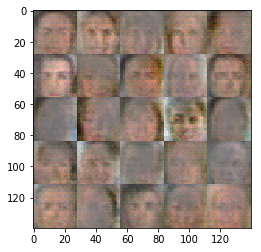

Epoch 1/1... Discriminator Loss: 1.1770 Generator Loss: 1.4539
Epoch 1/1... Discriminator Loss: 1.6742 Generator Loss: 0.3188
Epoch 1/1... Discriminator Loss: 0.5377 Generator Loss: 1.8718
Epoch 1/1... Discriminator Loss: 1.6279 Generator Loss: 0.3442


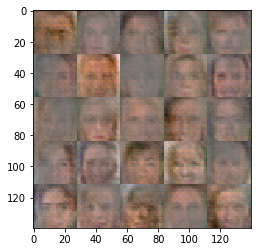

Epoch 1/1... Discriminator Loss: 0.9079 Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.1571 Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 0.9305 Generator Loss: 1.4892
Epoch 1/1... Discriminator Loss: 1.4666 Generator Loss: 0.3449


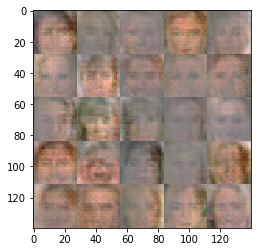

Epoch 1/1... Discriminator Loss: 1.4062 Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.1863 Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.0777 Generator Loss: 1.4206
Epoch 1/1... Discriminator Loss: 1.2168 Generator Loss: 0.4991


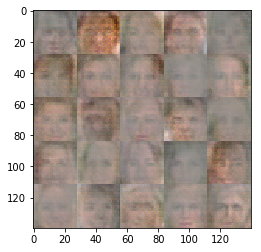

Epoch 1/1... Discriminator Loss: 0.9519 Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 1.5810 Generator Loss: 0.3108
Epoch 1/1... Discriminator Loss: 0.6940 Generator Loss: 2.1202
Epoch 1/1... Discriminator Loss: 1.0899 Generator Loss: 0.5842


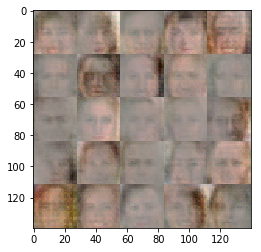

Epoch 1/1... Discriminator Loss: 0.8906 Generator Loss: 2.0781
Epoch 1/1... Discriminator Loss: 1.4408 Generator Loss: 0.3813
Epoch 1/1... Discriminator Loss: 0.7323 Generator Loss: 1.4708


KeyboardInterrupt: 

In [83]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.